# DensePose COCO数据集的可视化

本文档演示了图像标注（基于DensePose COCO）的可视化。

密集的COCO数据集标注在COCO标注框架中提供，可以直接使用pycocotools进行处理。

<br>
<div align="center">
  <img src="http://densepose.org/img/coords.png" width="400px" /><br>

   _Visualization of the partitioning of the surface and demonstration of "correspondence to a single point on a part"._
</div>

### 标注中的DensePose字段：
#### 收集的mask
* **“dp_makes”：** RLE编码的密集mask。所有部分mask的尺寸为256x256，映射到14个标签。请注意，这些mask没有链接到3D模板（即mask只是用来进行2D分割的，并不包含关键点或纹理的映射）。这些是从标注器收集的 **语义上有意义的部分** ，我们使用这些部分 **对标注点进行采样** （即挑选前景中含人体的部分）。

#### 标注点
* **'dp_x’**，**'dp_y’：** 图像上标注点的空间坐标。坐标被缩放，使得边界框大小为256x256。
* **'dp_I'：** 指示该标注点位于24个曲面面片（patch，指被分割的3D人体表面，具体见"RCNN-Texture-Transfer.ipynb"中的图1、图2）中的哪一个的面片索引。
* **'dp_U'**，**'dp_V'：** UV空间中的坐标。每个曲面面片都有单独的二维参数化。

在下文中，我们将整理得到的mask和标注点

In [1]:
from pycocotools.coco import COCO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
from random import randint

# 如果路径不对，将detectron_dir改为你的绝对路径
# detectron_dir = "D:\\projects\\DensePose\\modules\\detectron\\detectron"
detectron_dir = os.path.abspath("../modules/detectron/detectron")

coco_folder = os.path.join(detectron_dir, 'datasets/data/coco/')
dp_coco = COCO( os.path.join(coco_folder, 'annotations/densepose_coco_2014_minival.json'))

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!


选择一个随机图像，读取它并加载与此图像对应的标注。（此处我们固定选择minival中的第一个，即id为"458755"的图像）  
（如果需要修改图像，需要下载COCO val2014数据集，将所需图像放在DensePose/detectron/datasets/data/coco/val2014中；并在此处修改"Selected_im=458755"，458755可替换为自选的图像ID，为图像文件名后6位）

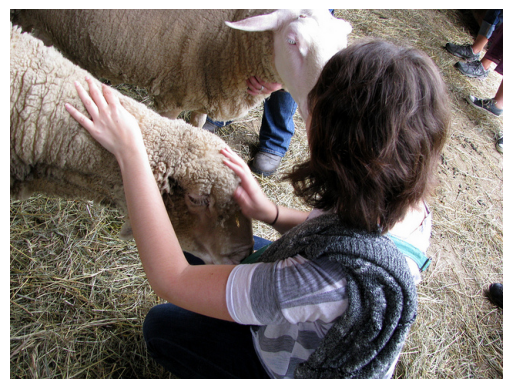

In [2]:
# Get img id's for the minival dataset.
im_ids = dp_coco.getImgIds()
# Select a random image id.
# Selected_im = im_ids[randint(0, len(im_ids))] # Choose im no 57 to replicate 
Selected_im = im_ids[0]
# Load the image
im = dp_coco.loadImgs(Selected_im)[0]  
# Load Anns for the selected image.
ann_ids = dp_coco.getAnnIds( imgIds=im['id'] )
anns = dp_coco.loadAnns(ann_ids)
# Now read and b
im_name = os.path.join( coco_folder + 'val2014', im['file_name'] )
I=cv2.imread(im_name)
plt.imshow(I[:,:,::-1]); plt.axis('off'); plt.show()

## 收集的mask的可视化

让我们在图像上可视化收集到的mask。

这些mask用于：
* 采样标注点，以得到密集的对应关系（图像与SMPL之间的）。
* 作为DensePose RCNN中的辅助损失。
* 以获得密集的FG/BG图（前景FrontGround/背景BackGround）。

从解码的mask（压缩mask）中获取密集mask的函数。

In [3]:
def GetDensePoseMask(Polys):
    MaskGen = np.zeros([256,256])
    for i in range(1,15):
        if(Polys[i-1]):
            current_mask = mask_util.decode(Polys[i-1])
            MaskGen[current_mask>0] = i
    return MaskGen

遍历所有的注释**anns**，并逐一处理。

198.1 0.0
0.7768627450980392 0.0


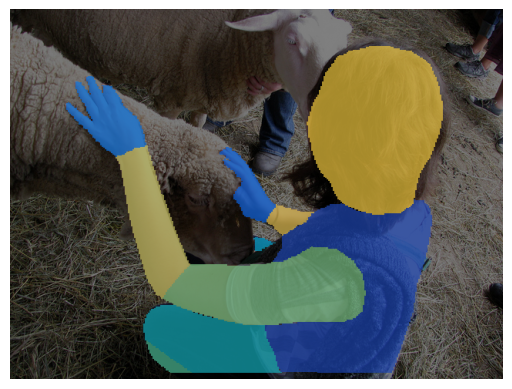

In [4]:
# 可视化mask：将原图颜色调低2倍，与mask进行3：7加权展示
I_vis=I.copy()/2 # Dim the image.

for ann in anns:  
    bbr =  np.array(ann['bbox']).astype(int) # the box.
    if( 'dp_masks' in ann.keys()): # If we have densepose annotation for this ann, 
        Mask = GetDensePoseMask(ann['dp_masks'])
        ################
        x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
        x2 = min( [ x2,I.shape[1] ] );  y2 = min( [ y2,I.shape[0] ] )
        ################ 
        MaskIm = cv2.resize( Mask, (int(x2-x1),int(y2-y1)) ,interpolation=cv2.INTER_NEAREST)
        MaskBool = np.tile((MaskIm==0)[:,:,np.newaxis],[1,1,3])
        #  Replace the visualized mask image with I_vis.
        Mask_vis = cv2.applyColorMap( (MaskIm*15).astype(np.uint8) , cv2.COLORMAP_PARULA)[:,:,:]
        Mask_vis[MaskBool]=I_vis[y1:y2,x1:x2,:][MaskBool]
        I_vis[y1:y2,x1:x2,:] = (I_vis[y1:y2,x1:x2,:]*0.3 + Mask_vis*0.7)

print(I_vis.max(), I_vis.min())
I_vis = I_vis/255.0
print(I_vis.flatten().max(), I_vis.flatten().min())
plt.imshow(I_vis[:,:,::-1]); plt.axis('off'); plt.show()

## 标注点的可视化

让我们在图像上可视化标注点。

对于每个标注点，我们都有表面曲面面片（patch）索引和UV坐标。

以下代码片段创建了分别由I、U和V坐标着色的图。其中I图中分割为24个部分（对应24个曲面），不同部分颜色不同；U、V表示各部分中的纹理参数化映射。

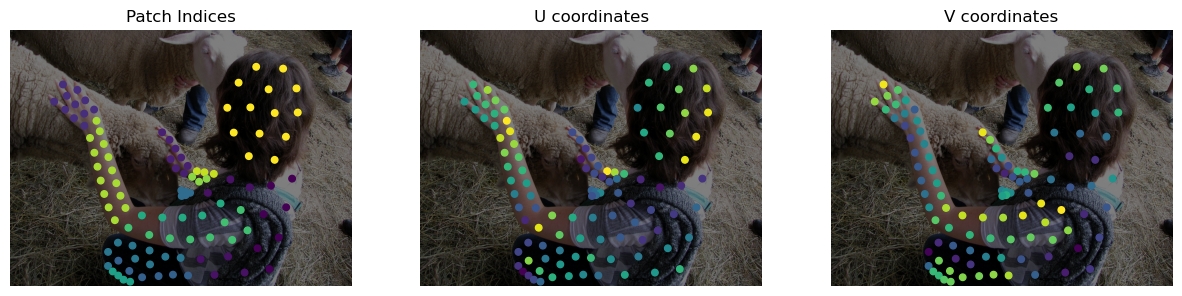

In [5]:
# 可视化mask：将原图颜色调低2倍，与mask进行3：7加权展示

# Show images for each subplot.
fig = plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(I[:,:,::-1]/2/255.);plt.axis('off');plt.title('Patch Indices')
plt.subplot(1,3,2)
plt.imshow(I[:,:,::-1]/2/255.);plt.axis('off');plt.title('U coordinates')
plt.subplot(1,3,3)
plt.imshow(I[:,:,::-1]/2/255.);plt.axis('off');plt.title('V coordinates')

## For each ann, scatter plot the collected points.
for ann in anns:
    bbr =  np.round(ann['bbox']) 
    if( 'dp_masks' in ann.keys()):
        Point_x = np.array(ann['dp_x'])/ 255. * bbr[2] # Strech the points to current box.
        Point_y = np.array(ann['dp_y'])/ 255. * bbr[3] # Strech the points to current box.
        #
        Point_I = np.array(ann['dp_I'])
        Point_U = np.array(ann['dp_U'])
        Point_V = np.array(ann['dp_V'])
        #
        x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
        x2 = min( [ x2,I.shape[1] ] ); y2 = min( [ y2,I.shape[0] ] )
        ###############
        Point_x = Point_x + x1 ; Point_y = Point_y + y1
        plt.subplot(1,3,1)
        plt.scatter(Point_x,Point_y,22,Point_I)
        plt.subplot(1,3,2)
        plt.scatter(Point_x,Point_y,22,Point_U)
        plt.subplot(1,3,3)
        plt.scatter(Point_x,Point_y,22,Point_V)
        
plt.show()